In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyod.utils.data import generate_data_clusters
from pyod.utils.data import generate_data

from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

from joblib import dump, load

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

random_state = np.random.RandomState(3)
outliers_fraction = 0.1

In [20]:
# Generate Data
# xtr, ytr = generate_data(n_train=200, n_test=50, n_features=2, contamination=0.1,
#                   train_only=True, offset=10, behaviour='new',
#                   random_state=random_state)


# xtr, xte, ytr, yte = generate_data(n_train=200, n_test=50, n_features=2, contamination=0.1,
#                   train_only=False, offset=10, behaviour='new',
#                   random_state=None)


xtr, xte, ytr, yte = generate_data_clusters(n_train=1000, n_test=500, n_clusters=5,
                       n_features=3, contamination=0.1, size='same',
                       density='same', dist=0.25, random_state=random_state,
                       return_in_clusters=False)

print('Xtr Shape: ' + str(xtr.shape))
print('Ytr Shape: ' + str(ytr.shape))

# print('Xte Shape: ' + str(xte.shape))
# print('Yte Shape: ' + str(yte.shape))


Xtr Shape: (1000, 3)
Ytr Shape: (1000,)


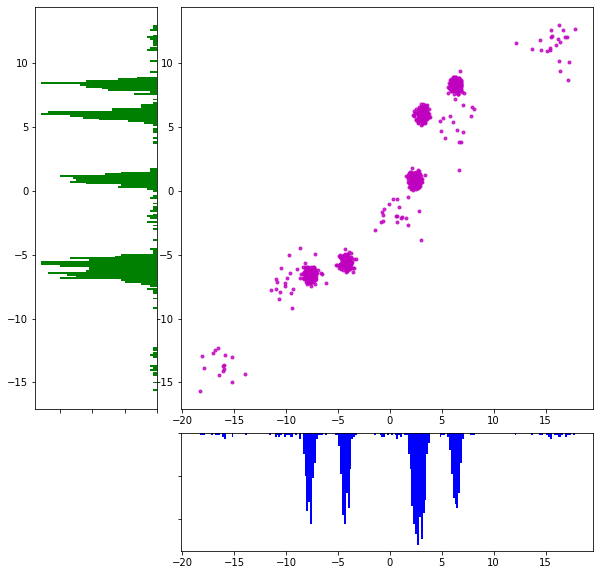

In [6]:
# Plot Data

# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(xtr[:,0], xtr[:,1],'mo', markersize=3, alpha=0.8)

# histogram on the attached axes
x_hist.hist(xtr[:,0], 200, histtype='stepfilled',
            orientation='vertical', color='blue')
x_hist.invert_yaxis()

y_hist.hist(xtr[:,1], 200, histtype='stepfilled',
            orientation='horizontal', color='green')
y_hist.invert_xaxis()




In [21]:
# Define outlier detection methods to be compared
classifiers = {
    'Isolation Forest': IForest(contamination=outliers_fraction, random_state=random_state),
   
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    
    'Average KNN': KNN(method='mean',contamination=outliers_fraction),
    
    'Local Outlier Factor (LOF)': LOF(n_neighbors=35, contamination=outliers_fraction),
}

# # List all detectors
# for i, clf in enumerate(classifiers.keys()):
#     print(repr(classifiers[clf]))

In [22]:
# Fit the models with the generated data and 
# compare model performances

# Fit the model
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print('\n \n',i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(xtr)
#     scores_pred = clf.decision_function(xtr) * -1
    y_pred = clf.predict(xtr)
#     threshold = np.percentile(scores_pred, 100 * outliers_fraction)
#     print('Threshold: ', threshold)
    n_errors = (y_pred != ytr).sum()
    print('Erros Training Data: ', n_errors)
    
    yte_pred = clf.predict(xte)
    nte_errors = (yte_pred != yte).sum()
    print('Erros Testing Data: ', nte_errors)
    print('First 5 samples',yte_pred[:5] )
    
    # Serielize model
    dump(clf, str(clf_name) + '.joblib')


 
 1 fitting Isolation Forest


/home/mks/anaconda3/envs/dev-env/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Erros Training Data:  8
Erros Testing Data:  1
First 5 samples [0 0 0 0 0]

 
 2 fitting K Nearest Neighbors (KNN)
Erros Training Data:  6
Erros Testing Data:  3
First 5 samples [0 0 0 0 0]

 
 3 fitting Average KNN
Erros Training Data:  4
Erros Testing Data:  2
First 5 samples [0 0 0 0 0]

 
 4 fitting Local Outlier Factor (LOF)
Erros Training Data:  8
Erros Testing Data:  4
First 5 samples [0 0 0 0 0]


In [9]:
old_det = classifiers['Isolation Forest']

In [10]:

dump(old_det, 'iForest.joblib')

['iForest.joblib']

In [11]:
new_det = load('iForest.joblib')

In [12]:
print(new_det)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=<mtrand.RandomState object at 0x7f2ab14ad090>, verbose=0)


In [18]:
import pickle


with open('iForest.pickle', 'wb') as handle:
    pickle.dump(old_det, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
with open('iForest.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

print(unserialized_data)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=<mtrand.RandomState object at 0x7f2aae871ea0>, verbose=0)


In [13]:
yte_pred = new_det.predict(xte)
nte_errors = (yte_pred != yte).sum()
print('Erros Testing Data: ', nte_errors)
print('First 5 samples',yte_pred[:5] )

Erros Testing Data:  1
First 5 samples [0 0 0 0 0]


In [ ]:
from pyod.utils.data import get_outliers_inliers
import matplotlib.pyplot as plt
def data_visualize(X_train, y_train, show_figure=True,
                   save_figure=False):

    def _plot(X_inliers, X_outliers, inlier_color='blue',
              outlier_color='orange'):
        plt.axis("equal")
        plt.scatter(X_inliers[:, 0], X_inliers[:, 1], label='inliers',
                    color=inlier_color, s=40)
        plt.scatter(X_outliers[:, 0], X_outliers[:, 1],
                    label='outliers', color=outlier_color, s=50, marker='^')
        plt.xticks([])
        plt.yticks([])
        plt.legend(loc='best', prop={'size': 10})

    assert len(X_train[0]) <= 5
    in_colors = ['blue', 'green', 'purple', 'brown', 'black']
    out_colors = ['red', 'orange', 'grey', 'violet', 'pink']
    plt.figure(figsize=(13, 10))
    plt.suptitle("Demo of Generating Data in Clusters", fontsize=15)
    for i, cluster in enumerate(X_train):
        X_train_outliers, X_train_inliers = get_outliers_inliers(cluster,
                                                                 y_train[i])
        _plot(X_train_inliers, X_train_outliers,
              inlier_color=in_colors[i%5],
              outlier_color=out_colors[i%5])

    if save_figure:
        plt.savefig()

    if show_figure:
        plt.show()
data_visualize(xtr, ytr, show_figure=True, save_figure=False)
# for i, cluster in enumerate(xtr):
#     print('i= ', i%5, '\n',cluster, '\n')

In [ ]:
X_train, X_test, y_train, y_test = generate_data_clusters(n_train=1000, n_test=500, n_clusters=4,
                       n_features=3, contamination=0.1, size='same',
                       density='same', dist=0.25, random_state=None,
                       return_in_clusters=True)

print(X_train.shape)

# from pyod.utils.example import data_visualize

# data_visualize(X_train, y_train, show_figure=True, save_figure=False)

In [ ]:
# Fit the models with the generated data and 
# compare model performances

# Fit the model
plt.figure(figsize=(15, 12))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(X_train)
    scores_pred = clf.decision_function(X_train) * -1
    y_pred = clf.predict(X_train)
    threshold = percentile(scores_pred, 100 * outliers_fraction)
    n_errors = (y_pred != ground_truth).sum()
    # plot the levels lines and the points

    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(3, 4, i + 1)
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                     cmap=plt.cm.Blues_r)
    a = subplot.contour(xx, yy, Z, levels=[threshold],
                        linewidths=2, colors='red')
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                     colors='orange')
    b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                        s=20, edgecolor='k')
    c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                        s=20, edgecolor='k')
    subplot.axis('tight')
    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')
    subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
    subplot.set_xlim((-7, 7))
    subplot.set_ylim((-7, 7))
plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
plt.suptitle("Outlier detection")
plt.show()

In [ ]:
# Create some normally distributed data
# import numpy as np
# mean = [0, 0]
# cov = [[1, 1], [1, 2]]
# x, y = np.random.multivariate_normal(mean, cov, 3000).T

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.subplot(311)
plt.plot(X_test[:,0])

plt.subplot(312)
plt.plot(X_test[:,1],'g')

plt.subplot(313)
plt.scatter(x=X_test[:,0], y=X_test[:,1],c=y_test)


plt.suptitle('Data')
plt.show()

In [ ]:
# Reference Node 3D Plotting:

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# X_train, X_test, y_train, y_test = generate_data_clusters(n_train=100, n_test=50, n_clusters=2,
#                        n_features=3, contamination=0.1, size='same',
#                        density='same', dist=0.30, random_state=None,
#                        return_in_clusters=False)

# data = pd.DataFrame(X_train,columns=['x1', 'x2', 'x3'])
# data['y'] = pd.Series(y_train)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # For each set of style and range settings, plot n random points in the box
# # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

# ax.scatter(data.x1, data.x2, data.x3,c=data.y,cmap='cool' )

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()